In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [1]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [2]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
# credit_card_default_eng = pd.read_csv('./Data/credit_card_default_eng.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng_features.RData') 
credit_card_default_eng = result[None]
# credit_card_default_eng.set_index('Unnamed: 0', inplace=True)
display(credit_card_default_eng.describe())
display(credit_card_default_eng.head())

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000
mean,3.99390,44976.945200,5275.232094,0.576423,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200
std,0.95845,63260.721860,10137.946323,16.499616,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518
min,3.00000,-56043.166667,0.000000,0.000000,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000
25%,3.00000,4781.333333,1113.291667,0.047855,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000
50%,4.00000,21051.833333,2397.166667,0.197668,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000
75%,5.00000,57104.416667,5583.916667,0.903817,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000
max,8.00000,877313.833333,627344.333333,2667.199955,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000


,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0


In [3]:
# clean data?
credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw[['data.group', 'DEFAULT']]
credit_card_default = credit_card_default.join(df_flags)
credit_card_default

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0,1,1
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0,3,1
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0,1,0
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0,3,0
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
29995,4.0,120891.500000,7091.666667,0.121471,0.561065,-0.716868,208365.0,20000.0,0.0,1,0
29996,5.0,3530.333333,2415.000000,0.807750,0.029302,0.023380,8979.0,8998.0,0.0,3,0
29997,4.0,11749.333333,5216.666667,0.272225,0.398450,0.567233,20878.0,22000.0,4.0,2,1
29998,5.0,44435.166667,24530.166667,0.481511,0.478171,0.168750,78379.0,85900.0,1.0,1,1


Prep for modeling

0    23364
1    23364
Name: DEFAULT, dtype: int64


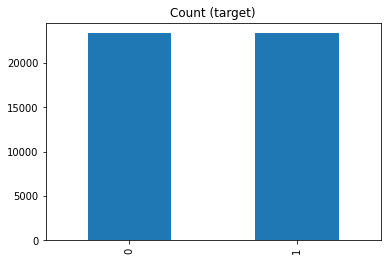

In [4]:
# Fix imbalance
count_class_0, count_class_1 = credit_card_default.DEFAULT.value_counts()

df_class_0 = credit_card_default[credit_card_default.DEFAULT == 0]
df_class_1 = credit_card_default[credit_card_default.DEFAULT == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_test_over.drop(columns=['age_bins'],inplace=True)

print(df_test_over.DEFAULT.value_counts())

df_test_over.DEFAULT.value_counts().plot(kind='bar', title='Count (target)');


In [5]:
ccd_train = df_test_over[df_test_over['data.group']==1].drop(columns=['data.group'])
ccd_test = df_test_over[df_test_over['data.group']==2].drop(columns=['data.group'])
ccd_validate = df_test_over[df_test_over['data.group']==3].drop(columns=['data.group'])

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (23952, 9)
test data size: (11105, 9)
validate data size: (11671, 9)


In [8]:
X_train = ccd_train[['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']]
X_test = ccd_test[~ccd_test.index.duplicated(keep='first')][['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']]

y_train = ccd_train['DEFAULT']
y_test = ccd_test[~ccd_test.index.duplicated(keep='first')]['DEFAULT']


In [9]:
all_features = X_train.columns
all_features = all_features.tolist()

In [10]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['pay_max', 'payment_avg', 'payment_max', 'ratio_avg', 'balance_growth_6mo']

[]

In [11]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [12]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )


5.c LR

In [26]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)


CPU times: total: 62.5 ms
Wall time: 58.5 ms


LogisticRegression()

In [27]:
np.round(model.coef_,2)

array([[ 0.55, -0.  ,  0.  , -0.11, -0.  ]])

In [22]:
newX

,Constant,pay_max,payment_avg,payment_max,ratio_avg,balance_growth_6mo
0,1.0,2.0,114.833333,689.0,0.800000,-0.19565
0,1.0,2.0,114.833333,689.0,0.800000,-0.19565
0,1.0,2.0,114.833333,689.0,0.800000,-0.19565
0,1.0,2.0,114.833333,689.0,0.800000,-0.19565
1,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
23949,1.0,3.0,566.833333,2101.0,0.043902,0.07960
23949,1.0,3.0,566.833333,2101.0,0.043902,0.07960
23949,1.0,3.0,566.833333,2101.0,0.043902,0.07960
23950,1.0,NaN,NaN,NaN,NaN,NaN


In [25]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
x = np.arange(10)[:, np.newaxis]
y = np.array([0,0,0,1,0,0,1,1,1,1])
print(logit_pvalue(model, X_train))


[1.66834366e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.44573664e-04 9.92236819e-01]


,precision,recall,f1-score,support
0,0.83,0.72,0.77,5766.00
1,0.29,0.44,0.35,1510.00
accuracy,0.66,0.66,0.66,0.66
macro avg,0.56,0.58,0.56,7276.00
weighted avg,0.72,0.66,0.68,7276.00


[[4127 1639]
 [ 852  658]]


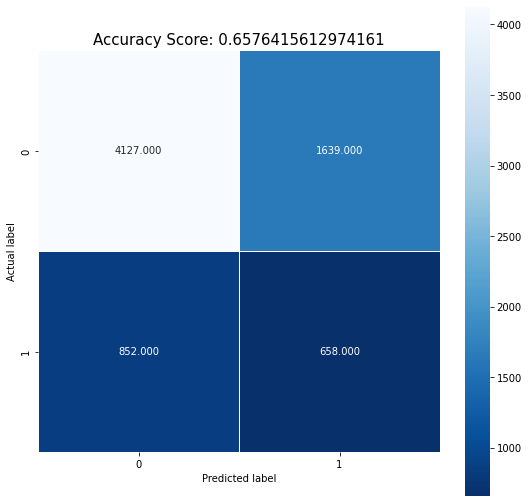

In [45]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


#### KS & ROC

In [46]:
def run_preds(model, x):
    prob_predictions = model.predict_proba(x)
    df = pd.DataFrame(prob_predictions)
    df['p'] = df.max(axis=1)
    df['y'] = df.idxmax(axis=1)
    return df

In [59]:
# Ref: https://www.listendata.com/2019/07/KS-Statistics-Python.html
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 20)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.abs(np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100)

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,21)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 100)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)



In [48]:
from sklearn.metrics import roc_curve,roc_auc_score

def plot_roc_curve(df): 
  fpr , tpr , thresholds = roc_curve( df.y , df.p)
  auc_score=roc_auc_score(df.y , df.p) 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.text(x=.1,y=.8,s="ROC curve (area = %0.2f)" % auc_score)
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  
  plt.show() 
  

#### Train

In [49]:
df_train = run_preds(model, X_train)

In [60]:
df_tr = ks(data=df_train,target="y", prob="p")
df_tr

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.703752  1.000000      72       1118      0.81%         7.51%   
2       0.625383  0.703723     172       1017      1.93%         6.83%   
3       0.588534  0.625362     260        930      2.92%         6.25%   
4       0.567236  0.588512     410        779      4.61%         5.23%   
5       0.552179  0.567214     415        770      4.66%         5.17%   
6       0.541356  0.552178     437        756      4.91%         5.08%   
7       0.533857  0.541338     529        661      5.94%         4.44%   
8       0.527268  0.533853     462        728      5.19%         4.89%   
9       0.522586  0.527259     483        706      5.43%         4.74%   
10      0.518767  0.522581     512        677      5.75%         4.55%   
11      0.515738  0.518766     479        707      5.38%         4.75%   
12      0.512980  0.515729     459    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.703752,1.000000,72,1118,0.81%,7.51%,0.81%,7.51%,6.7
2,0.625383,0.703723,172,1017,1.93%,6.83%,2.74%,14.34%,11.6
3,0.588534,0.625362,260,930,2.92%,6.25%,5.66%,20.59%,14.9
4,0.567236,0.588512,410,779,4.61%,5.23%,10.27%,25.82%,15.6
5,0.552179,0.567214,415,770,4.66%,5.17%,14.93%,31.00%,16.1
6,0.541356,0.552178,437,756,4.91%,5.08%,19.84%,36.07%,16.2
7,0.533857,0.541338,529,661,5.94%,4.44%,25.78%,40.51%,14.7
8,0.527268,0.533853,462,728,5.19%,4.89%,30.97%,45.41%,14.4
9,0.522586,0.527259,483,706,5.43%,4.74%,36.39%,50.15%,13.8


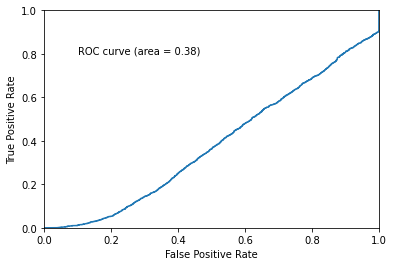

In [51]:

plot_roc_curve (df_train) 


#### Test

In [54]:
df_test = run_preds(model, X_test)

In [61]:
df_te = pd.DataFrame(ks(data=df_test,target="y", prob="p"))
df_te

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.736497  1.000000       5        359      0.22%         7.21%   
2       0.645235  0.736486      13        351      0.57%         7.05%   
3       0.605259  0.645158      48        316      2.09%         6.35%   
4       0.579392  0.605190      73        290      3.18%         5.82%   
5       0.561298  0.579212      90        274      3.92%         5.50%   
6       0.548764  0.561273     126        238      5.49%         4.78%   
7       0.540299  0.548750     114        250      4.96%         5.02%   
8       0.533392  0.540293     131        232      5.70%         4.66%   
9       0.527541  0.533351     134        230      5.83%         4.62%   
10      0.522825  0.527509     127        237      5.53%         4.76%   
11      0.518757  0.522800     141        223      6.14%         4.48%   
12      0.515653  0.518754     144    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.736497,1.000000,5,359,0.22%,7.21%,0.22%,7.21%,7.0
2,0.645235,0.736486,13,351,0.57%,7.05%,0.78%,14.26%,13.5
3,0.605259,0.645158,48,316,2.09%,6.35%,2.87%,20.61%,17.7
4,0.579392,0.605190,73,290,3.18%,5.82%,6.05%,26.43%,20.4
5,0.561298,0.579212,90,274,3.92%,5.50%,9.97%,31.93%,22.0
6,0.548764,0.561273,126,238,5.49%,4.78%,15.45%,36.71%,21.3
7,0.540299,0.548750,114,250,4.96%,5.02%,20.42%,41.74%,21.3
8,0.533392,0.540293,131,232,5.70%,4.66%,26.12%,46.39%,20.3
9,0.527541,0.533351,134,230,5.83%,4.62%,31.95%,51.01%,19.1


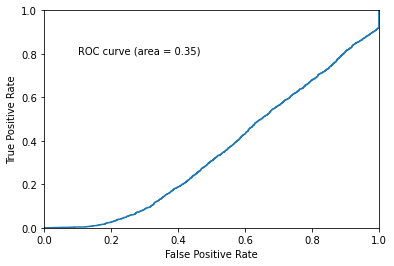

In [56]:

plot_roc_curve (df_test) 
